# PyTorch Layer 이해하기

# 예제 불러오기

In [78]:
import torch
from torchvision import datasets, transforms

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=1)

In [80]:
image, label = next(iter(train_loader))

In [81]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

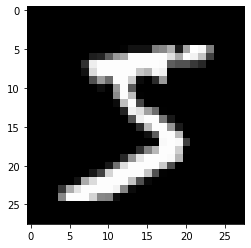

In [82]:
plt.imshow(image[0,0,:,:],'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [83]:
import torch
import torch.nn as nn #weight가 포함됨.
import torch.nn.functional as F # max_pooling등등 포함됨.

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [116]:
nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5, stride=1) 
# Tensor는 outchannel만 있음. 얼마 내보낼 것인지 . 
# 여기는 얼마 받을 건지 in_channel


Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [85]:
layer = nn.Conv2d(1,20,5,1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [124]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [125]:
### 학습 가능한,즉 말랑말랑한 상태임
weight = weight.detach().numpy() 

In [126]:
weight.shape

(20, 1, 5, 5)

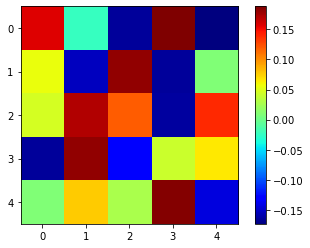

In [127]:
plt.imshow(weight[0,0,:,:],'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [90]:
output_data = layer(image)


In [91]:
output_data =output_data.data

In [92]:
output = output_data.cpu().numpy() #cpu() 
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [93]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

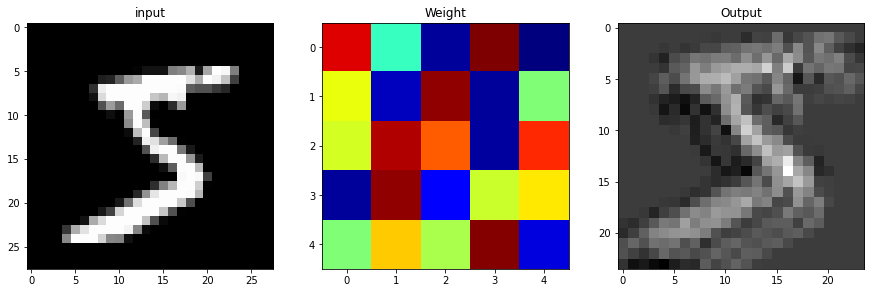

In [94]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()
# input 과 convolution(weight)랑 합쳐져서 ouput이 나옴.

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [95]:
image.shape

torch.Size([1, 1, 28, 28])

In [96]:
pool = F.max_pool2d(image,2,2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [97]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [98]:
image_arr.shape

(1, 1, 28, 28)

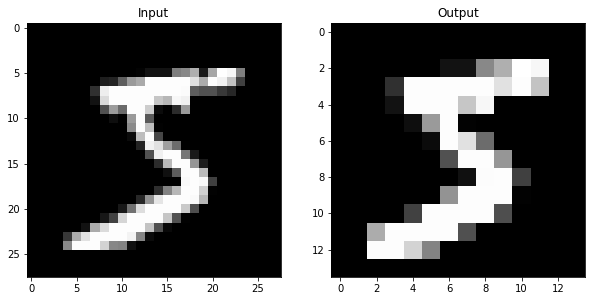

In [102]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr),'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr),'gray') # pooling : 압축같은거 

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [104]:
image.shape

torch.Size([1, 1, 28, 28])

In [109]:
flatten = image.view(1,1*28*28) # 배치사이즈는 유지할것
flatten.shape

torch.Size([1, 784])

In [113]:
lin = nn.Linear(784, 10)(flatten) # 784 -> 10개로 내보냄
lin.shape

torch.Size([1, 10])

In [114]:
lin

tensor([[-0.0128,  0.3196, -0.0115, -0.5317,  0.2240,  0.1668, -0.0396, -0.4920,
         -0.3260,  0.1245]], grad_fn=<AddmmBackward>)

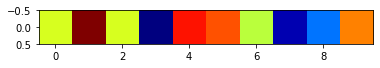

In [128]:
plt.imshow(lin.detach().numpy(),'jet') # linear는 weight가 존재하기 떄문에 detach
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [131]:
with torch.no_grad():
    flatten = image.view(1,1*28*28)
    lin = nn.Linear(784,10)(flatten)
    softmax = F.softmax(lin,dim=1)

In [132]:
softmax

tensor([[0.0887, 0.1260, 0.0975, 0.0999, 0.1201, 0.0833, 0.0867, 0.1032, 0.0824,
         0.1122]])

In [135]:
np.sum(softmax.numpy()) # linear를 numpy로 만들고 싶다면 이런 과정을 거쳐야함.

1.0

# # Layer 중 Convolution, Linear는 Weight가 존재하기 때문에 처리방법이 다름

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [148]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1) # 20을 받고 50을 내보내고
        self.fc1 = nn.Linear(4*4*50,500) # Linear는 Fully Conntected!
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x): # 위에 학습 가능한 레이어를 만들고 여기에 적용함
        # Convlution은 relu를 거침
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x= F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        print(x.shape) # nn.Linear(4*4*50,500)알아내기
        #Fully Conntected (Classification)
        x = x.view(-1, 4*4*50) # 펼쳐주는데 앞의 배치 사이즈는 미정이라 -1
        x = F.relu(self.fc1(x)) # Linear에 들어갔다가 activation FUnction에 들어감
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # dim = 1 뒤의 열을 기준으로 

- Image를 Model에 넣어서 결과 확인

In [145]:
model = Net()

In [146]:
result = model.forward(image)
result

torch.Size([1, 50, 4, 4])


tensor([[-2.2391, -2.3186, -2.3097, -2.2708, -2.3000, -2.2861, -2.3230, -2.3708,
         -2.3190, -2.2944]], grad_fn=<LogSoftmaxBackward>)

In [150]:
model.conv1 # layer 한개 가져오기

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))